# Project Report

Project made by Inès DUFLOS and Nourchen MARZOUKI

## Introduction

In this project, we will use various tools available in Python to analyze a set of genes collected post-mortem from patients with ALS or without. Our goal will be to identify genes that may be associated with ALS.

## Step 1 - Data Preprocessing

#### Gather RNA Counts

In this section, we have assembled all the gene samples into a dataframe named 'data_matrix'.

In [1]:
import zipfile

# Define the path to your zip file
zip_file_path = './Data.zip'  # Change this to the path of your zip file

# Define the directory where you want to extract the contents
extracted_folder_path = './Data'  # Change this to the directory where you want to extract

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Print a message indicating that extraction is complete
print("Extraction complete.")

Extraction complete.


In [2]:
import pandas as pd
import glob
import re

path = "./Data"  # Define the path of the data

pdList = []  # Variable to temporarily store all dataframes (one for each txt file)

# Iterate over all txt files in the specified path
for fname in glob.glob(path + "/*.txt"):
    # Read the txt file into a dataframe
    df = pd.read_table(fname)

    # Search the name of the sample in the file name
    sample_name = re.search("GSM\d+", fname).group()

    # Rename the index (rows) using the column containing the gene name
    df.rename(index=df["gene/TE"], inplace=True)

    # Drop the first column containing the gene name, no longer needed
    df.drop(columns=df.columns[0], axis=1, inplace=True)

    # Rename the column (there is only one column at this step) using the sample name
    df.rename(columns={df.columns[0]: sample_name}, inplace=True)

    # Add the current dataframe to the list
    pdList.append(df)

# Concatenate all dataframes into one dataframe
data_matrix = pd.concat(pdList, axis=1)

# Transpose the dataframe to get a more standard shape (samples x variables)
data_matrix = data_matrix.transpose()

In [3]:
data_matrix

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3533316,33,83,0,1023,81,182,2,0,14,0,...,676,1338,1373,768,82,396,111,345,1233,1506
GSM3533369,35,109,0,760,90,98,0,0,49,1,...,928,1972,1870,1033,77,582,135,425,1866,1799
GSM3533298,37,93,0,2475,137,174,5,1,18,1,...,821,1837,1828,942,85,449,110,396,1596,1637
GSM3533234,22,102,0,1706,83,178,1,3,31,0,...,966,2295,1993,1152,96,582,124,539,1742,1939
GSM3533337,31,110,0,1484,84,60,1,1,12,0,...,656,1357,1345,749,61,341,102,346,1122,1437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM3533290,16,107,0,3994,88,186,2,2,42,0,...,757,1751,1444,859,74,403,101,395,1436,1606
GSM3533344,17,43,4,900,73,113,1,2,6,1,...,727,1561,1372,702,83,350,99,351,1256,1479
GSM3533305,43,92,0,2322,53,61,3,5,60,0,...,625,1299,1179,711,66,289,59,271,982,1101
GSM3533265,43,93,0,4265,103,85,0,0,67,2,...,940,1697,1718,824,86,441,109,433,1599,2175


#### Gather Sample Annotations

In this section, we created a dataframe named 'data_annotation' where we included various information related to the samples that could be useful, such as the region from which the sample was taken or whether the patient was affected by ALS or not. Additionally, we linked this dataframe with 'data_matrix' by including corresponding row numbers in the 'Num_ligne_matrix' column.

In [4]:
import xml.etree.ElementTree as et

# Initialize the dataframe to store data annotation
data_annotation = pd.DataFrame(columns=['Sample_id', 'Cns_subregion'])

# Parse the XML file
xtree = et.parse('./Data/GSE124439_family.xml')

# Get the root of the XML tree
xroot = xtree.getroot()

# Iterate over each element named "Sample" in the XML tree
for child in xroot.iter("{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}Sample"):
    # Extract sample id from the attribute of the current node
    temp_sample_id = child.attrib['iid']

    # Initialize temporary variables for sample characteristics
    temp_cns_subregion = None

    # Iterate over each element named "Characteristics" for the current sample
    for child2 in child.iter("{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}Characteristics"):
        if child2.attrib["tag"] == "cns subregion":
            # Extract CNS subregion information
            temp_cns_subregion = child2.text.replace('\n', '')

    # Create a temporary dataframe for the current sample's data
    temp_df = pd.DataFrame({'Sample_id': [temp_sample_id], 'Cns_subregion': [temp_cns_subregion]})

    # Concatenate the temporary dataframe to the main data annotation dataframe
    data_annotation = pd.concat([data_annotation, temp_df])

# Reset the index of the final dataframe
data_annotation.reset_index(drop=True, inplace=True)

In [5]:
data_annotation = pd.DataFrame(columns=['Sample_id', 'Cns_subregion', 'Subject_id', 'Tissue_type', 'Sample_group'])  # Initialize the dataframe

xtree = et.parse('./Data/GSE124439_family.xml')  # Parse the XML file
xroot = xtree.getroot()  # Get the root of the XML tree to start exploration

# Iterate over each element named "Sample" in the XML tree
for child in xroot.iter("{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}Sample"):
    temp_sample_id = child.attrib['iid']  # Extract sample id from the attribute of the current node
    temp_subject_id = None  # Initialize subject id
    temp_cns_subregion = None  # Initialize CNS subregion
    temp_tissue_type = None  # Initialize tissue type
    temp_sample_group = None  # Initialize sample group

    # Iterate over each element named "Characteristics" for the current sample
    for child2 in child.iter("{http://www.ncbi.nlm.nih.gov/geo/info/MINiML}Characteristics"):
        if child2.attrib["tag"] == "cns subregion":
            temp_cns_subregion = child2.text.replace('\n', '')  # Extract CNS subregion
        elif child2.attrib["tag"] == "subject id":
            temp_subject_id = child2.text.replace('\n', '')  # Extract subject id
        elif child2.attrib["tag"] == "tissue type":
            temp_tissue_type = child2.text.replace('\n', '')  # Extract tissue type
        elif child2.attrib["tag"] == "sample group":
            temp_sample_group = child2.text.replace('\n', '')  # Extract sample group

    # Create a temporary dataframe for the current sample's data
    temp_df = pd.DataFrame({'Sample_id': [temp_sample_id],
                            'Cns_subregion': [temp_cns_subregion],
                            'Subject_id': [temp_subject_id],
                            'Tissue_type': [temp_tissue_type],
                            'Sample_group': [temp_sample_group]})

    # Concatenate the temporary dataframe to the main data annotation dataframe
    data_annotation = pd.concat([data_annotation, temp_df])

# Reset the index of the final dataframe
data_annotation.reset_index(drop=True, inplace=True)

In [6]:
# Print the value counts for 'Cns_subregion' column
print(data_annotation['Cns_subregion'].value_counts())
print()

# Print the value counts for 'Tissue_type' column
print(data_annotation['Tissue_type'].value_counts())
print()

# Print the value counts for 'Sample_group' column
print(data_annotation['Sample_group'].value_counts())
print()

# Print the value counts for 'Subject_id' column
print(data_annotation['Subject_id'].value_counts())

Cns_subregion
Frontal Cortex                  81
Motor Cortex (Medial)           45
Motor Cortex (Lateral)          45
Motor Cortex                     5
Name: count, dtype: int64

Tissue_type
post-mortem tissue          176
Name: count, dtype: int64

Sample_group
ALS Spectrum MND                      145
Non-Neurological Control               17
Other Neurological Disorders           14
Name: count, dtype: int64

Subject_id
NEUEL133AK6          3
NEUUE532LFF          3
NEUEF397VVN          3
NEUWZ373ZHA          3
NEUAT369TG5          3
                    ..
NEUZB953VCD          1
NEUNL974RU6          1
JHU 75               1
JHU 77               1
NEUPU334DL1          1
Name: count, Length: 95, dtype: int64


In [7]:
def get_line_number(x):
    """
    Function to get the line number (index) of a sample ID in the data_matrix DataFrame.
    If the sample ID is found, returns its line number; otherwise, returns None.
    """
    if x in data_matrix.index:  # Check if the sample ID is present in the index of data_matrix
        return data_matrix.index.get_loc(x)  # If found, return its line number
    else:
        return None  # If not found, return None

# Apply the get_line_number function to the 'Sample_id' column of data_annotation DataFrame
# to get the line number (index) of each sample ID in the data_matrix DataFrame
data_annotation['Num_ligne_matrix'] = data_annotation['Sample_id'].apply(get_line_number)

# Drop rows with missing values in the 'Num_ligne_matrix' column
data_annotation.dropna(subset=['Num_ligne_matrix'], inplace=True)

In [8]:
# Sort the data_annotation DataFrame by the 'Num_ligne_matrix' column
data_annotation = data_annotation.sort_values(by='Num_ligne_matrix')

# Set the 'Sample_id' column as the index of the data_annotation DataFrame
data_annotation = data_annotation.set_index('Sample_id')

In [9]:
data_annotation

,Cns_subregion,Subject_id,Tissue_type,Sample_group,Num_ligne_matrix
Sample_id,,,,,
GSM3533316,Frontal Cortex,NEUTP019MY9,post-mortem tissue,ALS Spectrum MND,0
GSM3533369,Frontal Cortex,NEUZB953VCD,post-mortem tissue,ALS Spectrum MND,1
GSM3533298,Motor Cortex (Medial),GWF14-01,post-mortem tissue,Other Neurological Disorders,2
GSM3533234,Frontal Cortex,NEUEC006FND,post-mortem tissue,ALS Spectrum MND,3
GSM3533337,Frontal Cortex,NEUWP285RM6,post-mortem tissue,ALS Spectrum MND,4
...,...,...,...,...,...
GSM3533290,Motor Cortex (Medial),NEURD711XCL,post-mortem tissue,Non-Neurological Control,171
GSM3533344,Motor Cortex (Lateral),NEUTB398FC9,post-mortem tissue,ALS Spectrum MND,172
GSM3533305,Motor Cortex (Lateral),NEUWZ373ZHA,post-mortem tissue,ALS Spectrum MND,173


The following code is intended to ensure the correctness of the dataframe. We manually obtained various pieces of information regarding randomly chosen Sample_ids and tested whether these pieces of information matched those in the dataframe.

In [10]:
# Test 1
test1 = data_annotation.loc['GSM3533240']  # Retrieve the row with Sample_id 'GSM3533240' from data_annotation
if (test1['Cns_subregion'] == 'Frontal Cortex      '  # Check if the CNS subregion matches
    and test1['Subject_id'] == 'NEUYB686REL      '  # Check if the Subject_id matches
    and test1['Tissue_type'] == 'post-mortem tissue      '  # Check if the Tissue_type matches
    and test1['Sample_group'] == 'ALS Spectrum MND      '):  # Check if the Sample_group matches
    print('TEST 1 RÉUSSI')  # If all conditions are met, print 'TEST 1 RÉUSSI' (Test 1 successful)
else:
    print('ERREUR TEST 1')  # If any condition fails, print 'ERREUR TEST 1' (Test 1 failed)

# Test 2
test2 = data_annotation.loc['GSM3533251']  # Retrieve the row with Sample_id 'GSM3533251' from data_annotation
if (test2['Cns_subregion'] == 'Motor Cortex (Medial)      '  # Check if the CNS subregion matches
    and test2['Subject_id'] == 'NEUHC282LVJ      '  # Check if the Subject_id matches
    and test2['Tissue_type'] == 'post-mortem tissue      '  # Check if the Tissue_type matches
    and test2['Sample_group'] == 'Non-Neurological Control      '):  # Check if the Sample_group matches
    print('TEST 2 RÉUSSI')  # If all conditions are met, print 'TEST 2 RÉUSSI' (Test 2 successful)
else:
    print('ERREUR TEST 2')  # If any condition fails, print 'ERREUR TEST 2' (Test 2 failed)


TEST 1 RÉUSSI
TEST 2 RÉUSSI


#### Create Initial Preprocessing Functions

In [11]:
class ALS_RNAseq:
    def __init__(self):
        self.__data_matrix = set()

    def get_data_matrix(self):
        return self.__data_matrix

    def set_data_matrix(self, matrix):
        self.__data_matrix = matrix

    def __str__(self):
        return "put here what you want to print"

In [12]:
datam = ALS_RNAseq()
datam.set_data_matrix(data_matrix)

## Step 2 - Descriptive Analysis

In this section, we utilized several methods to visualize our data in order to gain a better understanding and facilitate their subsequent utilization.

#### Sample Description:

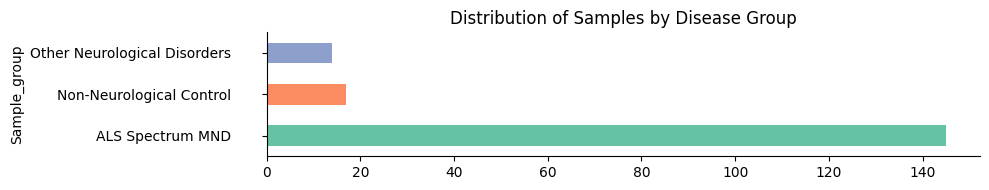

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(10, 2))

# Set the title of the plot
plt.title('Distribution of Samples by Disease Group')

# Group the data by 'Sample_group', calculate the size of each group, and plot it as a horizontal bar plot
data_annotation.groupby('Sample_group').size().plot(kind='barh', color=sns.palettes.mpl_palette("Set2"))

# Remove top and right spines from the plot
plt.gca().spines[['top', 'right']].set_visible(False)

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()

Here we can observe an imbalance in the data, with significantly more patients affected by ALS than patients without any neurological disease or with other neurological conditions.

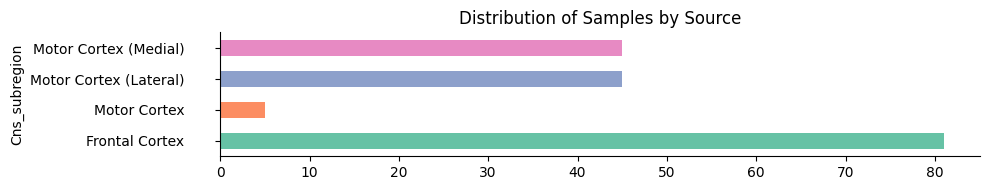

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with specific dimensions
plt.figure(figsize=(10, 2))

# Set the title of the plot
plt.title('Distribution of Samples by Source')

# Group data by 'Cns_subregion' and get the size of each group, then plot it as a horizontal bar chart
data_annotation.groupby('Cns_subregion').size().plot(kind='barh', color=sns.palettes.mpl_palette("Set2"))

# Remove top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Adjust layout to prevent overlapping elements
plt.tight_layout()

# Display the plot
plt.show()

Here, we observe an imbalance in the data, with more samples taken from the frontal cortex and very few samples taken from the motor cortex without specifying medial or lateral regions.

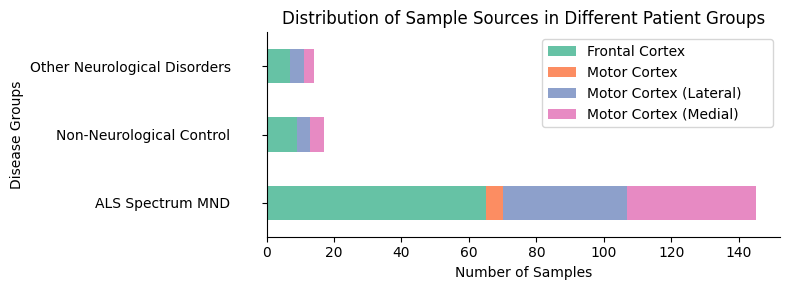

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a cross-tabulation of 'Sample_group' and 'Cns_subregion'
cross_tab = pd.crosstab(data_annotation['Sample_group'], data_annotation['Cns_subregion'])

# Plot the cross-tabulation as a horizontal stacked bar chart
cross_tab.plot(kind='barh', stacked=True, figsize=(8, 3), color=sns.palettes.mpl_palette("Set2"))

# Set the title of the plot
plt.title('Distribution of Sample Sources in Different Patient Groups')

# Set labels for the x and y axes
plt.ylabel('Disease Groups')
plt.xlabel('Number of Samples')

# Display the legend
plt.legend()

# Remove top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Adjust layout to prevent overlapping elements
plt.tight_layout()

# Show the plot
plt.show()

Here, we can observe the distribution of where the samples were taken within each patient group. It is apparent that the distribution within each group is fairly balanced.

In [16]:
import pandas as pd

# Calculate the mean values per row of the data matrix
means_per_row = data_matrix.mean(axis=1)

# Print the mean values per row
print(means_per_row)

# Print the mean of the mean values per row
print(means_per_row.mean())

# Print the median of the mean values per row
print(means_per_row.median())

# Print the standard deviation of the mean values per row
print(means_per_row.std())

GSM3533316     874.052257
GSM3533369     697.773909
GSM3533298     769.895693
GSM3533234     906.813525
GSM3533337     840.968984
                 ...     
GSM3533290     800.363382
GSM3533344     601.598176
GSM3533305     859.590992
GSM3533265    1029.472421
GSM3533294     967.272718
Length: 176, dtype: float64
888.4218394309901
857.947535661244
216.23162313435375


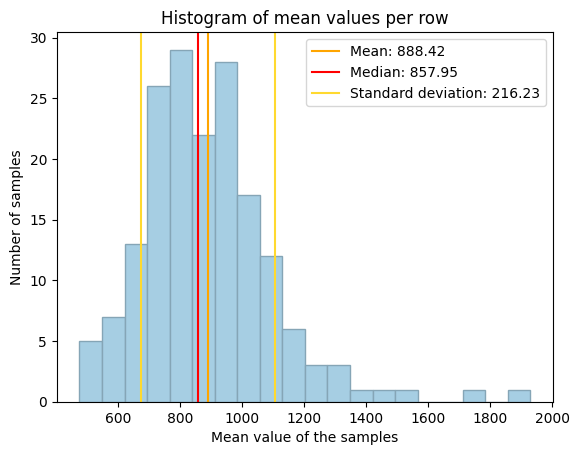

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the means along the columns axis
means_per_row = data_matrix.mean(axis=1)
mean_value = means_per_row.mean()
median_value = np.median(means_per_row)
std_value = means_per_row.std()

# Create a histogram with seaborn color palette
plt.hist(means_per_row, bins=20, color='#a6cee3', edgecolor='#85a5b6')

# Display the mean
plt.axvline(mean_value, color='orange', label=f'Mean: {mean_value:.2f}')
plt.annotate(f'Mean: {mean_value:.2f}', xy=(mean_value, 50), xytext=(mean_value+0.1*np.std(means_per_row), 100),
             arrowprops=dict(facecolor='orange'))

# Display the median
plt.axvline(median_value, color='red', label=f'Median: {median_value:.2f}')
plt.annotate(f'Median: {median_value:.2f}', xy=(median_value, 50), xytext=(median_value+0.1*np.std(means_per_row), 150),
             arrowprops=dict(facecolor='red'))

# Display the standard deviation
plt.axvline(mean_value + std_value, color='#ffd92f', label=f'Standard deviation: {std_value:.2f}')
plt.axvline(mean_value - std_value, color='#ffd92f')
plt.annotate(f'Standard deviation: {std_value:.2f}', xy=(mean_value + std_value, 50), xytext=(mean_value + 1.5*np.std(means_per_row), 200),
             arrowprops=dict(facecolor='#ffd92f'))

# Add labels and a title
plt.xlabel('Mean value of the samples')
plt.ylabel('Number of samples')
plt.title('Histogram of mean values per row')

# Show the legend
plt.legend()

# Show the histogram
plt.show()

##### samples that have a mean of over 1200

Here, we can see the distribution of gene means for each patient. It's notable that there are some patients whose gene means are significantly higher than those of other patients. Below, we display the samples that have a mean of over 1200.

In [18]:
# Create a mask to filter rows where mean value per row is greater than or equal to 1200
mask = means_per_row >= 1200

# Use the mask to select rows from the data matrix where mean value per row is above 1200
rows_above_1200 = data_matrix[mask]

# Display the selected rows
rows_above_1200

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3533343,56,219,6,4688,150,129,2,4,40,0,...,1041,2134,1901,1023,84,533,132,563,1751,2131
GSM3533258,85,166,3,3833,225,60,1,3,57,0,...,1285,2944,2814,1465,217,756,148,600,2649,2692
GSM3533361,92,341,0,2660,163,288,0,11,78,0,...,1194,2785,2520,1308,123,632,163,655,2479,2930
GSM3533276,78,120,0,6849,158,76,5,1,57,0,...,1068,2064,1979,948,131,446,100,464,1776,2084
GSM3533293,38,166,0,5970,190,153,0,0,129,1,...,980,1951,1968,976,101,466,129,549,1618,2049
GSM3533243,44,162,0,3776,105,83,4,1,105,0,...,1097,2549,2335,1336,126,618,159,645,2227,2870
GSM3533404,124,332,0,3516,141,173,3,2,192,0,...,743,1846,1680,936,110,479,120,503,1646,1839
GSM3533364,58,228,0,3953,227,260,4,5,83,4,...,1824,4240,3761,2046,235,1180,255,954,3946,3902
GSM3533402,134,300,0,6077,171,42,8,5,225,0,...,719,1988,1691,966,119,460,109,399,1619,1724
GSM3533302,63,292,2,4053,207,293,5,4,42,2,...,1481,2959,2836,1516,152,725,206,754,2652,3049


In [19]:
print("GSM3533276 : " + data_annotation.loc['GSM3533276']['Sample_group'] + "\n" + #
      "GSM3533243 : " + data_annotation.loc['GSM3533243']['Sample_group'] + "\n" + #
      "GSM3533364 : " + data_annotation.loc['GSM3533364']['Sample_group'] + "\n" +
      "GSM3533293 : " + data_annotation.loc['GSM3533293']['Sample_group'] + "\n" + #
      "GSM3533361 : " + data_annotation.loc['GSM3533361']['Sample_group'] + "\n" +
      "GSM3533402 : " + data_annotation.loc['GSM3533402']['Sample_group'] + "\n" +
      "GSM3533343 : " + data_annotation.loc['GSM3533343']['Sample_group'] + "\n" + #
      "GSM3533302 : " + data_annotation.loc['GSM3533302']['Sample_group'] + "\n" +
      "GSM3533267 : " + data_annotation.loc['GSM3533267']['Sample_group'] + "\n" + #
      "GSM3533258 : " + data_annotation.loc['GSM3533258']['Sample_group'] + "\n" + #
      "GSM3533404 : " + data_annotation.loc['GSM3533404']['Sample_group'])

GSM3533276 : ALS Spectrum MND      
GSM3533243 : ALS Spectrum MND      
GSM3533364 : ALS Spectrum MND      
GSM3533293 : ALS Spectrum MND      
GSM3533361 : ALS Spectrum MND      
GSM3533402 : ALS Spectrum MND      
GSM3533343 : ALS Spectrum MND      
GSM3533302 : ALS Spectrum MND      
GSM3533267 : ALS Spectrum MND      
GSM3533258 : ALS Spectrum MND      
GSM3533404 : ALS Spectrum MND      


##### samples that have a mean of below 600

Now that we have seen the repartition of patient genes above 1400 we going to look closely at the patients whose genes mean are lower than 600. Below, we display the samples that have a mean of below 600.

In [20]:
# Create a mask to filter rows where mean value per row is less than or equal to 600
mask = means_per_row <= 600

# Use the mask to select rows from the data matrix where mean value per row is below 600
rows_below_600 = data_matrix[mask]

# Display the selected rows
rows_below_600

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,X6B_LINE:CR1:LINE,X7A_LINE:CR1:LINE,X7B_LINE:CR1:LINE,X7C_LINE:CR1:LINE,X7D_LINE:CR1:LINE,X8_LINE:CR1:LINE,X9_LINE:L1:LINE,Zaphod2:hAT-Tip100:DNA,Zaphod3:hAT-Tip100:DNA,Zaphod:hAT-Tip100:DNA
GSM3533381,19,77,0,2251,45,133,4,10,182,0,...,300,879,850,530,39,240,36,258,884,915
GSM3533263,30,63,0,1024,34,56,1,0,9,0,...,288,640,644,352,30,179,46,136,614,723
GSM3533273,10,69,0,844,66,49,1,2,18,0,...,739,1500,1470,782,85,405,78,389,1431,1607
GSM3533307,18,69,0,946,55,74,0,4,4,2,...,568,1401,1148,703,56,410,81,334,1213,1210
GSM3533325,36,47,0,2620,108,130,7,4,70,0,...,585,1327,1320,716,82,437,94,268,1100,1047
GSM3533386,21,65,0,3587,96,324,4,2,92,0,...,557,1372,1272,809,73,376,77,278,1030,1073
GSM3533347,22,103,0,1315,50,78,0,3,15,1,...,552,1278,1182,625,57,358,71,351,1210,1312
GSM3533345,22,114,0,1340,60,153,2,1,29,0,...,468,1090,898,587,69,305,67,225,963,975
GSM3533235,15,39,0,957,74,48,1,2,21,0,...,446,1066,1022,635,63,267,65,256,866,977


In [21]:
print("GSM3533347 : " + data_annotation.loc['GSM3533347']['Sample_group'] + "\n" +
      "GSM3533235 : " + data_annotation.loc['GSM3533235']['Sample_group'] + "\n" +
      "GSM3533263 : " + data_annotation.loc['GSM3533263']['Sample_group'] + "\n" +
      "GSM3533325 : " + data_annotation.loc['GSM3533325']['Sample_group'] + "\n" +
      "GSM3533381 : " + data_annotation.loc['GSM3533381']['Sample_group'] + "\n" +
      "GSM3533386 : " + data_annotation.loc['GSM3533386']['Sample_group'] + "\n" +
      "GSM3533307 : " + data_annotation.loc['GSM3533307']['Sample_group'] + "\n" +
      "GSM3533345 : " + data_annotation.loc['GSM3533345']['Sample_group'] + "\n" +
      "GSM3533273 : " + data_annotation.loc['GSM3533273']['Sample_group'])

GSM3533347 : ALS Spectrum MND      
GSM3533235 : ALS Spectrum MND      
GSM3533263 : ALS Spectrum MND      
GSM3533325 : ALS Spectrum MND      
GSM3533381 : Non-Neurological Control      
GSM3533386 : ALS Spectrum MND      
GSM3533307 : ALS Spectrum MND      
GSM3533345 : ALS Spectrum MND      
GSM3533273 : ALS Spectrum MND      


#### RNA Counts Description:

In [22]:
import pandas as pd

# Calculate the mean values per column of the data matrix
column_means = data_matrix.mean()

# Print the mean values per column
print(column_means)

# Print the mean of the mean values per column
print(column_means.mean())

# Print the median of the mean values per column
print(column_means.median())

# Print the standard deviation of the mean values per column
print(column_means.std())

A1BG                        38.062500
A1BG-AS1                   118.568182
A1CF                         0.170455
A2M                       2455.403409
A2M-AS1                    102.568182
                             ...     
X8_LINE:CR1:LINE           462.647727
X9_LINE:L1:LINE            110.863636
Zaphod2:hAT-Tip100:DNA     415.931818
Zaphod3:hAT-Tip100:DNA    1555.630682
Zaphod:hAT-Tip100:DNA     1735.556818
Length: 28953, dtype: float64
888.4218394309901
78.0284090909091
5513.503024933467


##### Top 10 genes with the highest mean

In [23]:
# Get the top 10 largest mean values across all columns
top_values = data_matrix.mean().nlargest(10)

# Print the top 10 values
print("Top 10 values:")
print(top_values)

Top 10 values:
MIRb:MIR:SINE     366426.198864
MALAT1            323309.613636
L2a:L2:LINE       283476.306818
MIR:MIR:SINE      275949.971591
L2c:L2:LINE       241241.857955
AluJb:Alu:SINE    165322.568182
MIRc:MIR:SINE     161914.727273
L2b:L2:LINE       144328.835227
MIR3:MIR:SINE     136115.954545
AluSx:Alu:SINE    130978.284091
dtype: float64


###### Looking deeper into patients who have those genes at a high level

In the next section, we will examine the sample group and CNS subregion where genes were sampled for patients with the highest level of genes with the highest average values.

1) MIRb:MIR:SINE

In [24]:
print(data_matrix['MIRb:MIR:SINE'].nlargest(5))
print("GSM3533364 : " + data_annotation.loc['GSM3533364']['Sample_group'] + ", " + data_annotation.loc['GSM3533364']['Cns_subregion'] + "\n" +
      "GSM3533367 : " + data_annotation.loc['GSM3533367']['Sample_group'] + ", " + data_annotation.loc['GSM3533367']['Cns_subregion'] + "\n" +
      "GSM3533240 : " + data_annotation.loc['GSM3533240']['Sample_group'] + ", " + data_annotation.loc['GSM3533240']['Cns_subregion'] + "\n" +
      "GSM3533302 : " + data_annotation.loc['GSM3533302']['Sample_group'] + ", " + data_annotation.loc['GSM3533302']['Cns_subregion'] + "\n" +
      "GSM3533373 : " + data_annotation.loc['GSM3533373']['Sample_group'] + ", " + data_annotation.loc['GSM3533373']['Cns_subregion'] + "\n" )

GSM3533364    884080
GSM3533367    633992
GSM3533240    624561
GSM3533302    622276
GSM3533373    621877
Name: MIRb:MIR:SINE, dtype: int64
GSM3533364 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533367 : Non-Neurological Control      , Motor Cortex (Lateral)      
GSM3533240 : ALS Spectrum MND      , Frontal Cortex      
GSM3533302 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533373 : ALS Spectrum MND      , Motor Cortex (Lateral)      



2) MALAT1

In [25]:
print(data_matrix['MALAT1'].nlargest(5))
print("GSM3533364 : " + data_annotation.loc['GSM3533364']['Sample_group'] + ", " + data_annotation.loc['GSM3533364']['Cns_subregion'] + "\n" +
      "GSM3533240 : " + data_annotation.loc['GSM3533240']['Sample_group'] + ", " + data_annotation.loc['GSM3533240']['Cns_subregion'] + "\n" +
      "GSM3533258 : " + data_annotation.loc['GSM3533258']['Sample_group'] + ", " + data_annotation.loc['GSM3533258']['Cns_subregion'] + "\n" +
      "GSM3533234 : " + data_annotation.loc['GSM3533234']['Sample_group'] + ", " + data_annotation.loc['GSM3533234']['Cns_subregion'] + "\n" +
      "GSM3533243 : " + data_annotation.loc['GSM3533243']['Sample_group'] + ", " + data_annotation.loc['GSM3533243']['Cns_subregion'] + "\n" )

GSM3533364    674885
GSM3533240    649380
GSM3533258    624772
GSM3533234    597093
GSM3533243    590259
Name: MALAT1, dtype: int64
GSM3533364 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533240 : ALS Spectrum MND      , Frontal Cortex      
GSM3533258 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533234 : ALS Spectrum MND      , Frontal Cortex      
GSM3533243 : ALS Spectrum MND      , Motor Cortex (Medial)      



3) L2a:L2:LINE

In [26]:
print(data_matrix['L2a:L2:LINE'].nlargest(5))
print("GSM3533364 : " + data_annotation.loc['GSM3533364']['Sample_group'] + ", " + data_annotation.loc['GSM3533364']['Cns_subregion'] + "\n" +
      "GSM3533373 : " + data_annotation.loc['GSM3533373']['Sample_group'] + ", " + data_annotation.loc['GSM3533373']['Cns_subregion'] + "\n" +
      "GSM3533367 : " + data_annotation.loc['GSM3533367']['Sample_group'] + ", " + data_annotation.loc['GSM3533367']['Cns_subregion'] + "\n" +
      "GSM3533302 : " + data_annotation.loc['GSM3533302']['Sample_group'] + ", " + data_annotation.loc['GSM3533302']['Cns_subregion'] + "\n" +
      "GSM3533240 : " + data_annotation.loc['GSM3533240']['Sample_group'] + ", " + data_annotation.loc['GSM3533240']['Cns_subregion'] + "\n" )

GSM3533364    723528
GSM3533373    506045
GSM3533367    482378
GSM3533302    479104
GSM3533240    473762
Name: L2a:L2:LINE, dtype: int64
GSM3533364 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533373 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533367 : Non-Neurological Control      , Motor Cortex (Lateral)      
GSM3533302 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533240 : ALS Spectrum MND      , Frontal Cortex      



4) MIR:MIR:SINE

In [27]:
print(data_matrix['MIR:MIR:SINE'].nlargest(5))
print("GSM3533364 : " + data_annotation.loc['GSM3533364']['Sample_group'] + ", " + data_annotation.loc['GSM3533364']['Cns_subregion'] + "\n" +
      "GSM3533302 : " + data_annotation.loc['GSM3533302']['Sample_group'] + ", " + data_annotation.loc['GSM3533302']['Cns_subregion'] + "\n" +
      "GSM3533367 : " + data_annotation.loc['GSM3533367']['Sample_group'] + ", " + data_annotation.loc['GSM3533367']['Cns_subregion'] + "\n" +
      "GSM3533373 : " + data_annotation.loc['GSM3533373']['Sample_group'] + ", " + data_annotation.loc['GSM3533373']['Cns_subregion'] + "\n" +
      "GSM3533258 : " + data_annotation.loc['GSM3533258']['Sample_group'] + ", " + data_annotation.loc['GSM3533258']['Cns_subregion'] + "\n" )

GSM3533364    666669
GSM3533302    476993
GSM3533367    468325
GSM3533373    466830
GSM3533258    458220
Name: MIR:MIR:SINE, dtype: int64
GSM3533364 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533302 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533367 : Non-Neurological Control      , Motor Cortex (Lateral)      
GSM3533373 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533258 : ALS Spectrum MND      , Motor Cortex (Lateral)      



5) L2c:L2:LINE

In [28]:
print(data_matrix['L2c:L2:LINE'].nlargest(5))
print("GSM3533364 : " + data_annotation.loc['GSM3533364']['Sample_group'] + ", " + data_annotation.loc['GSM3533364']['Cns_subregion'] + "\n" +
      "GSM3533373 : " + data_annotation.loc['GSM3533373']['Sample_group'] + ", " + data_annotation.loc['GSM3533373']['Cns_subregion'] + "\n" +
      "GSM3533302 : " + data_annotation.loc['GSM3533302']['Sample_group'] + ", " + data_annotation.loc['GSM3533302']['Cns_subregion'] + "\n" +
      "GSM3533367 : " + data_annotation.loc['GSM3533373']['Sample_group'] + ", " + data_annotation.loc['GSM3533367']['Cns_subregion'] + "\n" +
      "GSM3533258 : " + data_annotation.loc['GSM3533258']['Sample_group'] + ", " + data_annotation.loc['GSM3533258']['Cns_subregion'] + "\n" )

GSM3533364    600056
GSM3533373    428802
GSM3533302    417766
GSM3533367    413312
GSM3533258    398129
Name: L2c:L2:LINE, dtype: int64
GSM3533364 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533373 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533302 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533367 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533258 : ALS Spectrum MND      , Motor Cortex (Lateral)      



6) AluJb:Alu:SINE

In [29]:
print(data_matrix['AluJb:Alu:SINE'].nlargest(5))
print("GSM3533364 : " + data_annotation.loc['GSM3533364']['Sample_group'] + ", " + data_annotation.loc['GSM3533364']['Cns_subregion'] + "\n" +
      "GSM3533361 : " + data_annotation.loc['GSM3533361']['Sample_group'] + ", " + data_annotation.loc['GSM3533361']['Cns_subregion'] + "\n" +
      "GSM3533285 : " + data_annotation.loc['GSM3533285']['Sample_group'] + ", " + data_annotation.loc['GSM3533285']['Cns_subregion'] + "\n" +
      "GSM3533382 : " + data_annotation.loc['GSM3533382']['Sample_group'] + ", " + data_annotation.loc['GSM3533382']['Cns_subregion'] + "\n" +
      "GSM3533240 : " + data_annotation.loc['GSM3533240']['Sample_group'] + ", " + data_annotation.loc['GSM3533240']['Cns_subregion'] + "\n" )

GSM3533364    456198
GSM3533361    329571
GSM3533285    328755
GSM3533382    320732
GSM3533240    293725
Name: AluJb:Alu:SINE, dtype: int64
GSM3533364 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533361 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533285 : ALS Spectrum MND      , Frontal Cortex      
GSM3533382 : ALS Spectrum MND      , Frontal Cortex      
GSM3533240 : ALS Spectrum MND      , Frontal Cortex      



7) MIRc:MIR:SINE

In [30]:
print(data_matrix['MIRc:MIR:SINE'].nlargest(5))
print("GSM3533364 : " + data_annotation.loc['GSM3533364']['Sample_group'] + ", " + data_annotation.loc['GSM3533364']['Cns_subregion'] + "\n" +
      "GSM3533302 : " + data_annotation.loc['GSM3533302']['Sample_group'] + ", " + data_annotation.loc['GSM3533302']['Cns_subregion'] + "\n" +
      "GSM3533367 : " + data_annotation.loc['GSM3533367']['Sample_group'] + ", " + data_annotation.loc['GSM3533367']['Cns_subregion'] + "\n" +
      "GSM3533373 : " + data_annotation.loc['GSM3533373']['Sample_group'] + ", " + data_annotation.loc['GSM3533373']['Cns_subregion'] + "\n" +
      "GSM3533240 : " + data_annotation.loc['GSM3533240']['Sample_group'] + ", " + data_annotation.loc['GSM3533240']['Cns_subregion'] + "\n" )

GSM3533364    384335
GSM3533302    277567
GSM3533367    277235
GSM3533373    271790
GSM3533240    269881
Name: MIRc:MIR:SINE, dtype: int64
GSM3533364 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533302 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533367 : Non-Neurological Control      , Motor Cortex (Lateral)      
GSM3533373 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533240 : ALS Spectrum MND      , Frontal Cortex      



8) L2b:L2:LINE

In [31]:
print(data_matrix['L2b:L2:LINE'].nlargest(5))
print("GSM3533364 : " + data_annotation.loc['GSM3533364']['Sample_group'] + ", " + data_annotation.loc['GSM3533364']['Cns_subregion'] + "\n" +
      "GSM3533373 : " + data_annotation.loc['GSM3533373']['Sample_group'] + ", " + data_annotation.loc['GSM3533373']['Cns_subregion'] + "\n" +
      "GSM3533240 : " + data_annotation.loc['GSM3533240']['Sample_group'] + ", " + data_annotation.loc['GSM3533240']['Cns_subregion'] + "\n" +
      "GSM3533367 : " + data_annotation.loc['GSM3533367']['Sample_group'] + ", " + data_annotation.loc['GSM3533367']['Cns_subregion'] + "\n" +
      "GSM3533302 : " + data_annotation.loc['GSM3533302']['Sample_group'] + ", " + data_annotation.loc['GSM3533302']['Cns_subregion'] + "\n" )

GSM3533364    362870
GSM3533373    255156
GSM3533240    254371
GSM3533367    253655
GSM3533302    239353
Name: L2b:L2:LINE, dtype: int64
GSM3533364 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533373 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533240 : ALS Spectrum MND      , Frontal Cortex      
GSM3533367 : Non-Neurological Control      , Motor Cortex (Lateral)      
GSM3533302 : ALS Spectrum MND      , Motor Cortex (Lateral)      



9) MIR3:MIR:SINE

In [32]:
print(data_matrix['MIR3:MIR:SINE'].nlargest(5))
print("GSM3533364 : " + data_annotation.loc['GSM3533364']['Sample_group'] + ", " + data_annotation.loc['GSM3533364']['Cns_subregion'] + "\n" +
      "GSM3533367 : " + data_annotation.loc['GSM3533367']['Sample_group'] + ", " + data_annotation.loc['GSM3533367']['Cns_subregion'] + "\n" +
      "GSM3533302 : " + data_annotation.loc['GSM3533302']['Sample_group'] + ", " + data_annotation.loc['GSM3533302']['Cns_subregion'] + "\n" +
      "GSM3533361 : " + data_annotation.loc['GSM3533361']['Sample_group'] + ", " + data_annotation.loc['GSM3533361']['Cns_subregion'] + "\n" +
      "GSM3533240 : " + data_annotation.loc['GSM3533240']['Sample_group'] + ", " + data_annotation.loc['GSM3533240']['Cns_subregion'] + "\n" )

GSM3533364    318973
GSM3533367    232364
GSM3533302    231352
GSM3533361    230372
GSM3533240    229550
Name: MIR3:MIR:SINE, dtype: int64
GSM3533364 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533367 : Non-Neurological Control      , Motor Cortex (Lateral)      
GSM3533302 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533361 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533240 : ALS Spectrum MND      , Frontal Cortex      



10) AluSx:Alu:SINE

In [33]:
print(data_matrix['AluSx:Alu:SINE'].nlargest(5))
print("GSM3533364 : " + data_annotation.loc['GSM3533364']['Sample_group'] + ", " + data_annotation.loc['GSM3533364']['Cns_subregion'] + "\n" +
      "GSM3533285 : " + data_annotation.loc['GSM3533285']['Sample_group'] + ", " + data_annotation.loc['GSM3533285']['Cns_subregion'] + "\n" +
      "GSM3533361 : " + data_annotation.loc['GSM3533361']['Sample_group'] + ", " + data_annotation.loc['GSM3533361']['Cns_subregion'] + "\n" +
      "GSM3533382 : " + data_annotation.loc['GSM3533382']['Sample_group'] + ", " + data_annotation.loc['GSM3533382']['Cns_subregion'] + "\n" +
      "GSM3533240 : " + data_annotation.loc['GSM3533240']['Sample_group'] + ", " + data_annotation.loc['GSM3533240']['Cns_subregion'] + "\n" )

GSM3533364    333249
GSM3533285    265975
GSM3533361    256914
GSM3533382    249241
GSM3533240    228885
Name: AluSx:Alu:SINE, dtype: int64
GSM3533364 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533285 : ALS Spectrum MND      , Frontal Cortex      
GSM3533361 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533382 : ALS Spectrum MND      , Frontal Cortex      
GSM3533240 : ALS Spectrum MND      , Frontal Cortex      



##### Top 10 genes with the smallest mean

In [34]:
# Get the top 10 smallest mean values across all columns
bottom_values = data_matrix.mean().nsmallest(10)

# Print the top 10 smallest values
print("Top 10 smallest values:")
print(bottom_values)

Top 10 smallest values:
ACTL7A          0.0
ACTL9           0.0
ACTR3BP2        0.0
ACTR3BP5        0.0
ADAM6           0.0
AMELY           0.0
AMY1C           0.0
ANO1-AS2        0.0
APOBEC1         0.0
APOBEC3B-AS1    0.0
dtype: float64


In [35]:
# Filter mean values greater than 0.056818 to remove rows with values equal to 0.0
# and rows where only 11 people have that gene (10/176 = 0.056818181818)
data_matrix_mean_without_zeros = data_matrix.mean().loc[data_matrix.mean() > 0.05681818181]

# Display the result
print(data_matrix_mean_without_zeros)

# Calculate the mean of the filtered mean values
print(data_matrix_mean_without_zeros.mean())

# Calculate the median of the filtered mean values
print(data_matrix_mean_without_zeros.median())

# Calculate the standard deviation of the filtered mean values
print(data_matrix_mean_without_zeros.std())

A1BG                        38.062500
A1BG-AS1                   118.568182
A1CF                         0.170455
A2M                       2455.403409
A2M-AS1                    102.568182
                             ...     
X8_LINE:CR1:LINE           462.647727
X9_LINE:L1:LINE            110.863636
Zaphod2:hAT-Tip100:DNA     415.931818
Zaphod3:hAT-Tip100:DNA    1555.630682
Zaphod:hAT-Tip100:DNA     1735.556818
Length: 26138, dtype: float64
984.101395608275
130.39772727272725
5794.700073420081


In [36]:
# Get the 10 smallest values after removing zeros
bottom_values_without_zeros = data_matrix_mean_without_zeros.nsmallest(10)

# Print a message indicating it's displaying the top 20 smallest values
print("Top 10 smallest values:")

# Print the 10 smallest values after removing zeros
print(bottom_values_without_zeros)

Top 10 smallest values:
AADACL4       0.056818
ALKBH3-AS1    0.056818
BANCR         0.056818
BRD7P3        0.056818
CD300LD       0.056818
CDH16         0.056818
CEACAM7       0.056818
CFHR2         0.056818
CMA1          0.056818
CPLX4         0.056818
dtype: float64


###### Looking deeper into patients who have those genes at a low level

In the next section, we will examine the sample group and CNS subregion where genes were sampled for patients with the lowest level of genes with the lowest average values.

1) AADACL4

In [37]:
print(data_matrix['AADACL4'].nlargest(5))
print("GSM3533270 : " + data_annotation.loc['GSM3533270']['Sample_group'] + ", " + data_annotation.loc['GSM3533270']['Cns_subregion'] + "\n" +
      "GSM3533259 : " + data_annotation.loc['GSM3533259']['Sample_group'] + ", " + data_annotation.loc['GSM3533259']['Cns_subregion'] + "\n" +
      "GSM3533377 : " + data_annotation.loc['GSM3533377']['Sample_group'] + ", " + data_annotation.loc['GSM3533377']['Cns_subregion'] + "\n" +
      "GSM3533335 : " + data_annotation.loc['GSM3533335']['Sample_group'] + ", " + data_annotation.loc['GSM3533335']['Cns_subregion'] + "\n" +
      "GSM3533319 : " + data_annotation.loc['GSM3533319']['Sample_group'] + ", " + data_annotation.loc['GSM3533319']['Cns_subregion'] + "\n" )

GSM3533259    2
GSM3533270    2
GSM3533377    1
GSM3533245    1
GSM3533320    1
Name: AADACL4, dtype: int64
GSM3533270 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533259 : Non-Neurological Control      , Motor Cortex (Lateral)      
GSM3533377 : ALS Spectrum MND      , Frontal Cortex      
GSM3533335 : Other Neurological Disorders      , Motor Cortex (Lateral)      
GSM3533319 : ALS Spectrum MND      , Motor Cortex (Medial)      



2) ALKBH3-AS1

In [38]:
print(data_matrix['ALKBH3-AS1'].nlargest(5))
print("GSM3533381 : " + data_annotation.loc['GSM3533381']['Sample_group'] + ", " + data_annotation.loc['GSM3533381']['Cns_subregion'] + "\n" +
      "GSM3533377 : " + data_annotation.loc['GSM3533377']['Sample_group'] + ", " + data_annotation.loc['GSM3533377']['Cns_subregion'] + "\n" +
      "GSM3533233 : " + data_annotation.loc['GSM3533233']['Sample_group'] + ", " + data_annotation.loc['GSM3533233']['Cns_subregion'] + "\n" +
      "GSM3533339 : " + data_annotation.loc['GSM3533339']['Sample_group'] + ", " + data_annotation.loc['GSM3533339']['Cns_subregion'] + "\n" +
      "GSM3533358 : " + data_annotation.loc['GSM3533358']['Sample_group'] + ", " + data_annotation.loc['GSM3533358']['Cns_subregion'] + "\n" )

GSM3533381    2
GSM3533377    1
GSM3533258    1
GSM3533340    1
GSM3533253    1
Name: ALKBH3-AS1, dtype: int64
GSM3533381 : Non-Neurological Control      , Frontal Cortex      
GSM3533377 : ALS Spectrum MND      , Frontal Cortex      
GSM3533233 : ALS Spectrum MND      , Frontal Cortex      
GSM3533339 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533358 : ALS Spectrum MND      , Motor Cortex (Lateral)      



3) BANCR

In [39]:
print(data_matrix['BANCR'].nlargest(5))
print("GSM3533289 : " + data_annotation.loc['GSM3533289']['Sample_group'] + ", " + data_annotation.loc['GSM3533289']['Cns_subregion'] + "\n" +
      "GSM3533252 : " + data_annotation.loc['GSM3533252']['Sample_group'] + ", " + data_annotation.loc['GSM3533252']['Cns_subregion'] + "\n" +
      "GSM3533361 : " + data_annotation.loc['GSM3533361']['Sample_group'] + ", " + data_annotation.loc['GSM3533361']['Cns_subregion'] + "\n" +
      "GSM3533310 : " + data_annotation.loc['GSM3533310']['Sample_group'] + ", " + data_annotation.loc['GSM3533310']['Cns_subregion'] + "\n" +
      "GSM3533299 : " + data_annotation.loc['GSM3533299']['Sample_group'] + ", " + data_annotation.loc['GSM3533299']['Cns_subregion'] + "\n" )

GSM3533289    2
GSM3533369    1
GSM3533361    1
GSM3533365    1
GSM3533404    1
Name: BANCR, dtype: int64
GSM3533289 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533252 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533361 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533310 : ALS Spectrum MND      , Frontal Cortex      
GSM3533299 : Other Neurological Disorders      , Motor Cortex (Lateral)      



4) BRD7P3

In [40]:
print(data_matrix['BRD7P3'].nlargest(5))
print("GSM3533324 : " + data_annotation.loc['GSM3533324']['Sample_group'] + ", " + data_annotation.loc['GSM3533324']['Cns_subregion'] + "\n" +
      "GSM3533291 : " + data_annotation.loc['GSM3533291']['Sample_group'] + ", " + data_annotation.loc['GSM3533291']['Cns_subregion'] + "\n" +
      "GSM3533297 : " + data_annotation.loc['GSM3533297']['Sample_group'] + ", " + data_annotation.loc['GSM3533297']['Cns_subregion'] + "\n" +
      "GSM3533232 : " + data_annotation.loc['GSM3533232']['Sample_group'] + ", " + data_annotation.loc['GSM3533232']['Cns_subregion'] + "\n" +
      "GSM3533235 : " + data_annotation.loc['GSM3533235']['Sample_group'] + ", " + data_annotation.loc['GSM3533235']['Cns_subregion'] + "\n" )

GSM3533324    2
GSM3533258    1
GSM3533283    1
GSM3533291    1
GSM3533354    1
Name: BRD7P3, dtype: int64
GSM3533324 : ALS Spectrum MND      , Frontal Cortex      
GSM3533291 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533297 : ALS Spectrum MND      , Motor Cortex      
GSM3533232 : ALS Spectrum MND      , Frontal Cortex      
GSM3533235 : ALS Spectrum MND      , Frontal Cortex      



5) CD300LD

In [41]:
print(data_matrix['CD300LD'].nlargest(5))
print("GSM3533250 : " + data_annotation.loc['GSM3533250']['Sample_group'] + ", " + data_annotation.loc['GSM3533250']['Cns_subregion'] + "\n" +
      "GSM3533248 : " + data_annotation.loc['GSM3533248']['Sample_group'] + ", " + data_annotation.loc['GSM3533248']['Cns_subregion'] + "\n" +
      "GSM3533369 : " + data_annotation.loc['GSM3533369']['Sample_group'] + ", " + data_annotation.loc['GSM3533369']['Cns_subregion'] + "\n" +
      "GSM3533251 : " + data_annotation.loc['GSM3533251']['Sample_group'] + ", " + data_annotation.loc['GSM3533251']['Cns_subregion'] + "\n" +
      "GSM3533259 : " + data_annotation.loc['GSM3533259']['Sample_group'] + ", " + data_annotation.loc['GSM3533259']['Cns_subregion'] + "\n" )

GSM3533250    6
GSM3533369    1
GSM3533259    1
GSM3533251    1
GSM3533248    1
Name: CD300LD, dtype: int64
GSM3533250 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533248 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533369 : ALS Spectrum MND      , Frontal Cortex      
GSM3533251 : Non-Neurological Control      , Motor Cortex (Medial)      
GSM3533259 : Non-Neurological Control      , Motor Cortex (Lateral)      



6) CDH16

In [42]:
print(data_matrix['CDH16'].nlargest(5))
print("GSM3533276 : " + data_annotation.loc['GSM3533276']['Sample_group'] + ", " + data_annotation.loc['GSM3533276']['Cns_subregion'] + "\n" +
      "GSM3533275 : " + data_annotation.loc['GSM3533275']['Sample_group'] + ", " + data_annotation.loc['GSM3533275']['Cns_subregion'] + "\n" +
      "GSM3533271 : " + data_annotation.loc['GSM3533271']['Sample_group'] + ", " + data_annotation.loc['GSM3533271']['Cns_subregion'] + "\n" +
      "GSM3533389 : " + data_annotation.loc['GSM3533389']['Sample_group'] + ", " + data_annotation.loc['GSM3533389']['Cns_subregion'] + "\n" +
      "GSM3533255 : " + data_annotation.loc['GSM3533255']['Sample_group'] + ", " + data_annotation.loc['GSM3533255']['Cns_subregion'] + "\n" )

GSM3533277    1
GSM3533405    1
GSM3533260    1
GSM3533276    1
GSM3533271    1
Name: CDH16, dtype: int64
GSM3533276 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533275 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533271 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533389 : Other Neurological Disorders      , Frontal Cortex      
GSM3533255 : ALS Spectrum MND      , Motor Cortex (Lateral)      



7) CEACAM7

In [43]:
print(data_matrix['CEACAM7'].nlargest(5))
print("GSM3533375 : " + data_annotation.loc['GSM3533375']['Sample_group'] + ", " + data_annotation.loc['GSM3533375']['Cns_subregion'] + "\n" +
      "GSM3533256 : " + data_annotation.loc['GSM3533256']['Sample_group'] + ", " + data_annotation.loc['GSM3533256']['Cns_subregion'] + "\n" +
      "GSM3533242 : " + data_annotation.loc['GSM3533242']['Sample_group'] + ", " + data_annotation.loc['GSM3533242']['Cns_subregion'] + "\n" +
      "GSM3533403 : " + data_annotation.loc['GSM3533403']['Sample_group'] + ", " + data_annotation.loc['GSM3533403']['Cns_subregion'] + "\n" +
      "GSM3533363 : " + data_annotation.loc['GSM3533363']['Sample_group'] + ", " + data_annotation.loc['GSM3533363']['Cns_subregion'] + "\n" )

GSM3533242    1
GSM3533363    1
GSM3533293    1
GSM3533403    1
GSM3533313    1
Name: CEACAM7, dtype: int64
GSM3533375 : ALS Spectrum MND      , Frontal Cortex      
GSM3533256 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533242 : ALS Spectrum MND      , Frontal Cortex      
GSM3533403 : ALS Spectrum MND      , Frontal Cortex      
GSM3533363 : ALS Spectrum MND      , Motor Cortex (Lateral)      



8) CFHR2

In [44]:
print(data_matrix['CFHR2'].nlargest(5))
print("GSM3533343 : " + data_annotation.loc['GSM3533343']['Sample_group'] + ", " + data_annotation.loc['GSM3533343']['Cns_subregion'] + "\n" +
      "GSM3533301 : " + data_annotation.loc['GSM3533301']['Sample_group'] + ", " + data_annotation.loc['GSM3533301']['Cns_subregion'] + "\n" +
      "GSM3533255 : " + data_annotation.loc['GSM3533255']['Sample_group'] + ", " + data_annotation.loc['GSM3533255']['Cns_subregion'] + "\n" +
      "GSM3533237 : " + data_annotation.loc['GSM3533237']['Sample_group'] + ", " + data_annotation.loc['GSM3533237']['Cns_subregion'] + "\n" +
      "GSM3533302 : " + data_annotation.loc['GSM3533302']['Sample_group'] + ", " + data_annotation.loc['GSM3533302']['Cns_subregion'] + "\n" )

GSM3533343    3
GSM3533301    2
GSM3533277    1
GSM3533258    1
GSM3533255    1
Name: CFHR2, dtype: int64
GSM3533343 : ALS Spectrum MND      , Frontal Cortex      
GSM3533301 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533255 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533237 : ALS Spectrum MND      , Frontal Cortex      
GSM3533302 : ALS Spectrum MND      , Motor Cortex (Lateral)      



9) CMA1

In [45]:
print(data_matrix['CMA1'].nlargest(5))
print("GSM3533301 : " + data_annotation.loc['GSM3533301']['Sample_group'] + ", " + data_annotation.loc['GSM3533301']['Cns_subregion'] + "\n" +
      "GSM3533274 : " + data_annotation.loc['GSM3533274']['Sample_group'] + ", " + data_annotation.loc['GSM3533274']['Cns_subregion'] + "\n" +
      "GSM3533341 : " + data_annotation.loc['GSM3533341']['Sample_group'] + ", " + data_annotation.loc['GSM3533341']['Cns_subregion'] + "\n" +
      "GSM3533312 : " + data_annotation.loc['GSM3533312']['Sample_group'] + ", " + data_annotation.loc['GSM3533312']['Cns_subregion'] + "\n" +
      "GSM3533334 : " + data_annotation.loc['GSM3533334']['Sample_group'] + ", " + data_annotation.loc['GSM3533334']['Cns_subregion'] + "\n" )

GSM3533301    2
GSM3533274    2
GSM3533341    1
GSM3533334    1
GSM3533312    1
Name: CMA1, dtype: int64
GSM3533301 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533274 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533341 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533312 : ALS Spectrum MND      , Motor Cortex (Lateral)      
GSM3533334 : Other Neurological Disorders      , Frontal Cortex      



10) CPLX4

In [46]:
print(data_matrix['CPLX4'].nlargest(5))
print("GSM3533289 : " + data_annotation.loc['GSM3533289']['Sample_group'] + ", " + data_annotation.loc['GSM3533289']['Cns_subregion'] + "\n" +
      "GSM3533375 : " + data_annotation.loc['GSM3533375']['Sample_group'] + ", " + data_annotation.loc['GSM3533375']['Cns_subregion'] + "\n" +
      "GSM3533332 : " + data_annotation.loc['GSM3533332']['Sample_group'] + ", " + data_annotation.loc['GSM3533332']['Cns_subregion'] + "\n" +
      "GSM3533350 : " + data_annotation.loc['GSM3533350']['Sample_group'] + ", " + data_annotation.loc['GSM3533350']['Cns_subregion'] + "\n" +
      "GSM3533314 : " + data_annotation.loc['GSM3533314']['Sample_group'] + ", " + data_annotation.loc['GSM3533314']['Cns_subregion'] + "\n" )

GSM3533289    2
GSM3533332    1
GSM3533314    1
GSM3533375    1
GSM3533327    1
Name: CPLX4, dtype: int64
GSM3533289 : ALS Spectrum MND      , Motor Cortex (Medial)      
GSM3533375 : ALS Spectrum MND      , Frontal Cortex      
GSM3533332 : Other Neurological Disorders      , Motor Cortex (Medial)      
GSM3533350 : ALS Spectrum MND      , Frontal Cortex      
GSM3533314 : ALS Spectrum MND      , Motor Cortex (Medial)      



## Step 3 - PCA

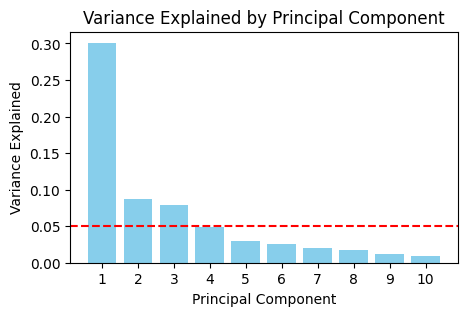

In [47]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_matrix)

# Perform PCA with up to 10 components
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance ratio
variance_explained = pca.explained_variance_ratio_

# Create a DataFrame to store the results
df_variance_explained = pd.DataFrame({'Component': range(1, 11), 'Variance Explained': variance_explained})

# Plot a bar graph to visualize the explained variance
plt.figure(figsize=(5, 3))
plt.bar(df_variance_explained['Component'], df_variance_explained['Variance Explained'], color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Principal Component')
plt.xticks(range(1, 11))

# Add a horizontal red dashed line at 0.05
plt.axhline(y=0.05, color='red', linestyle='--')

plt.show()

For the PCA we chose to use PC1, PC2 and PC3 because they have values above 0.05.

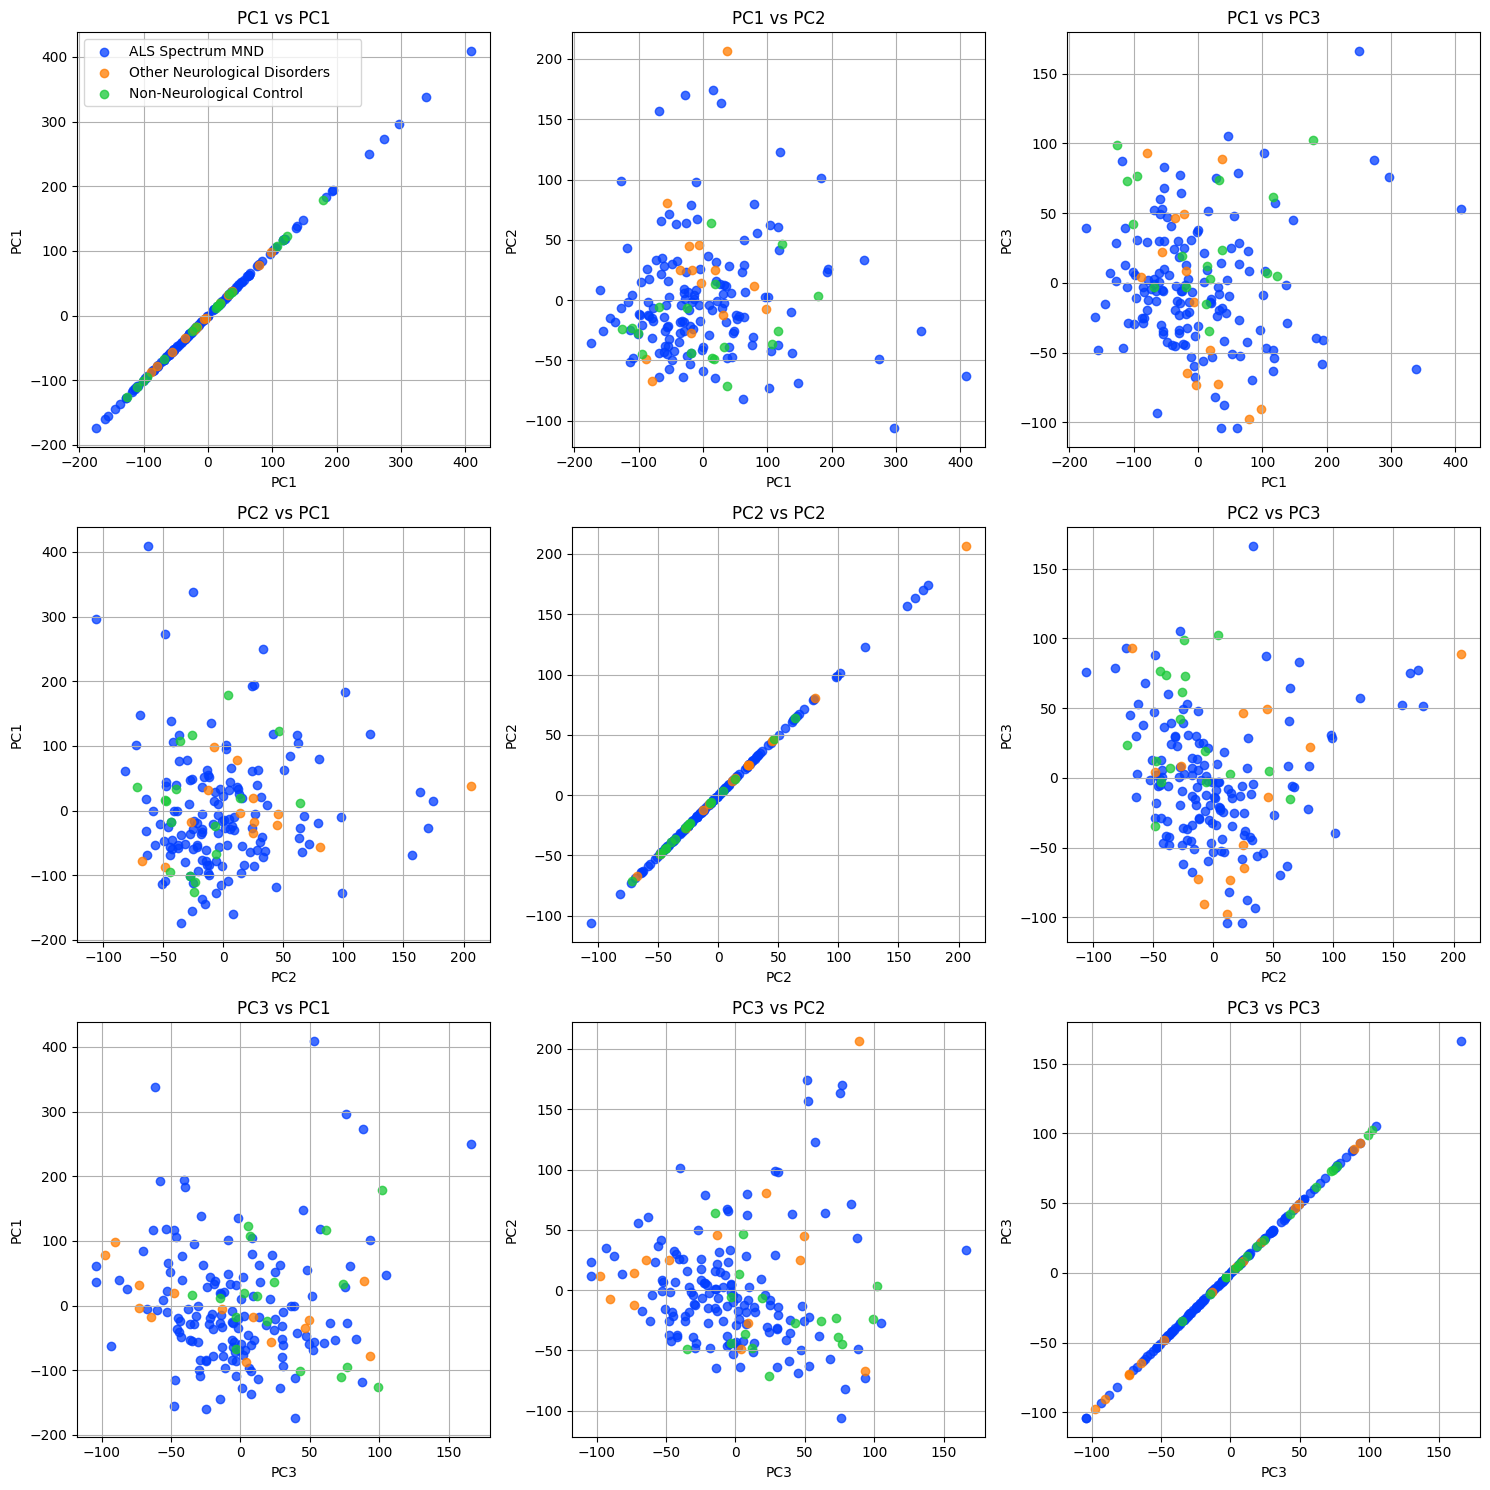

In [48]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn library

# Define the columns to use for PCA analysis
columns_pca = data_matrix.columns

# Define the column for color
color_column = 'Sample_group'

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_matrix[columns_pca])

# Perform a single PCA analysis for PC1, PC2 and PC3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Get the unique groups for color
groups = data_annotation[color_column].unique()

# Create a figure with a grid of subplots 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Perform PCA analysis for PC1, PC2 and PC3
for i in range(3):
    for j in range(3):
        # Plot the scatter plot for each group with specified color palette
        for idx, group in enumerate(groups):
            indices = data_annotation[color_column] == group
            if i == 0 and j == 0:  # Add legend only for the first plot
                axes[i, j].scatter(X_pca[indices, i], X_pca[indices, j], label=group, alpha=0.75, color=sns.color_palette("bright")[idx])
            else:
                axes[i, j].scatter(X_pca[indices, i], X_pca[indices, j], alpha=0.75, color=sns.color_palette("bright")[idx])

        # Title, labels, and legend only for the first plot
        if i == 0 and j == 0:
            axes[i, j].set_title(f'PC{i+1} vs PC{j+1}')
            axes[i, j].set_xlabel(f'PC{i+1}')
            axes[i, j].set_ylabel(f'PC{j+1}')
            axes[i, j].legend()
        else:
            axes[i, j].set_title(f'PC{i+1} vs PC{j+1}')
            axes[i, j].set_xlabel(f'PC{i+1}')
            axes[i, j].set_ylabel(f'PC{j+1}')
        axes[i, j].grid(True)

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

For the PCA above, we can see that it is quite difficult to differentiate between the different groups of patients.

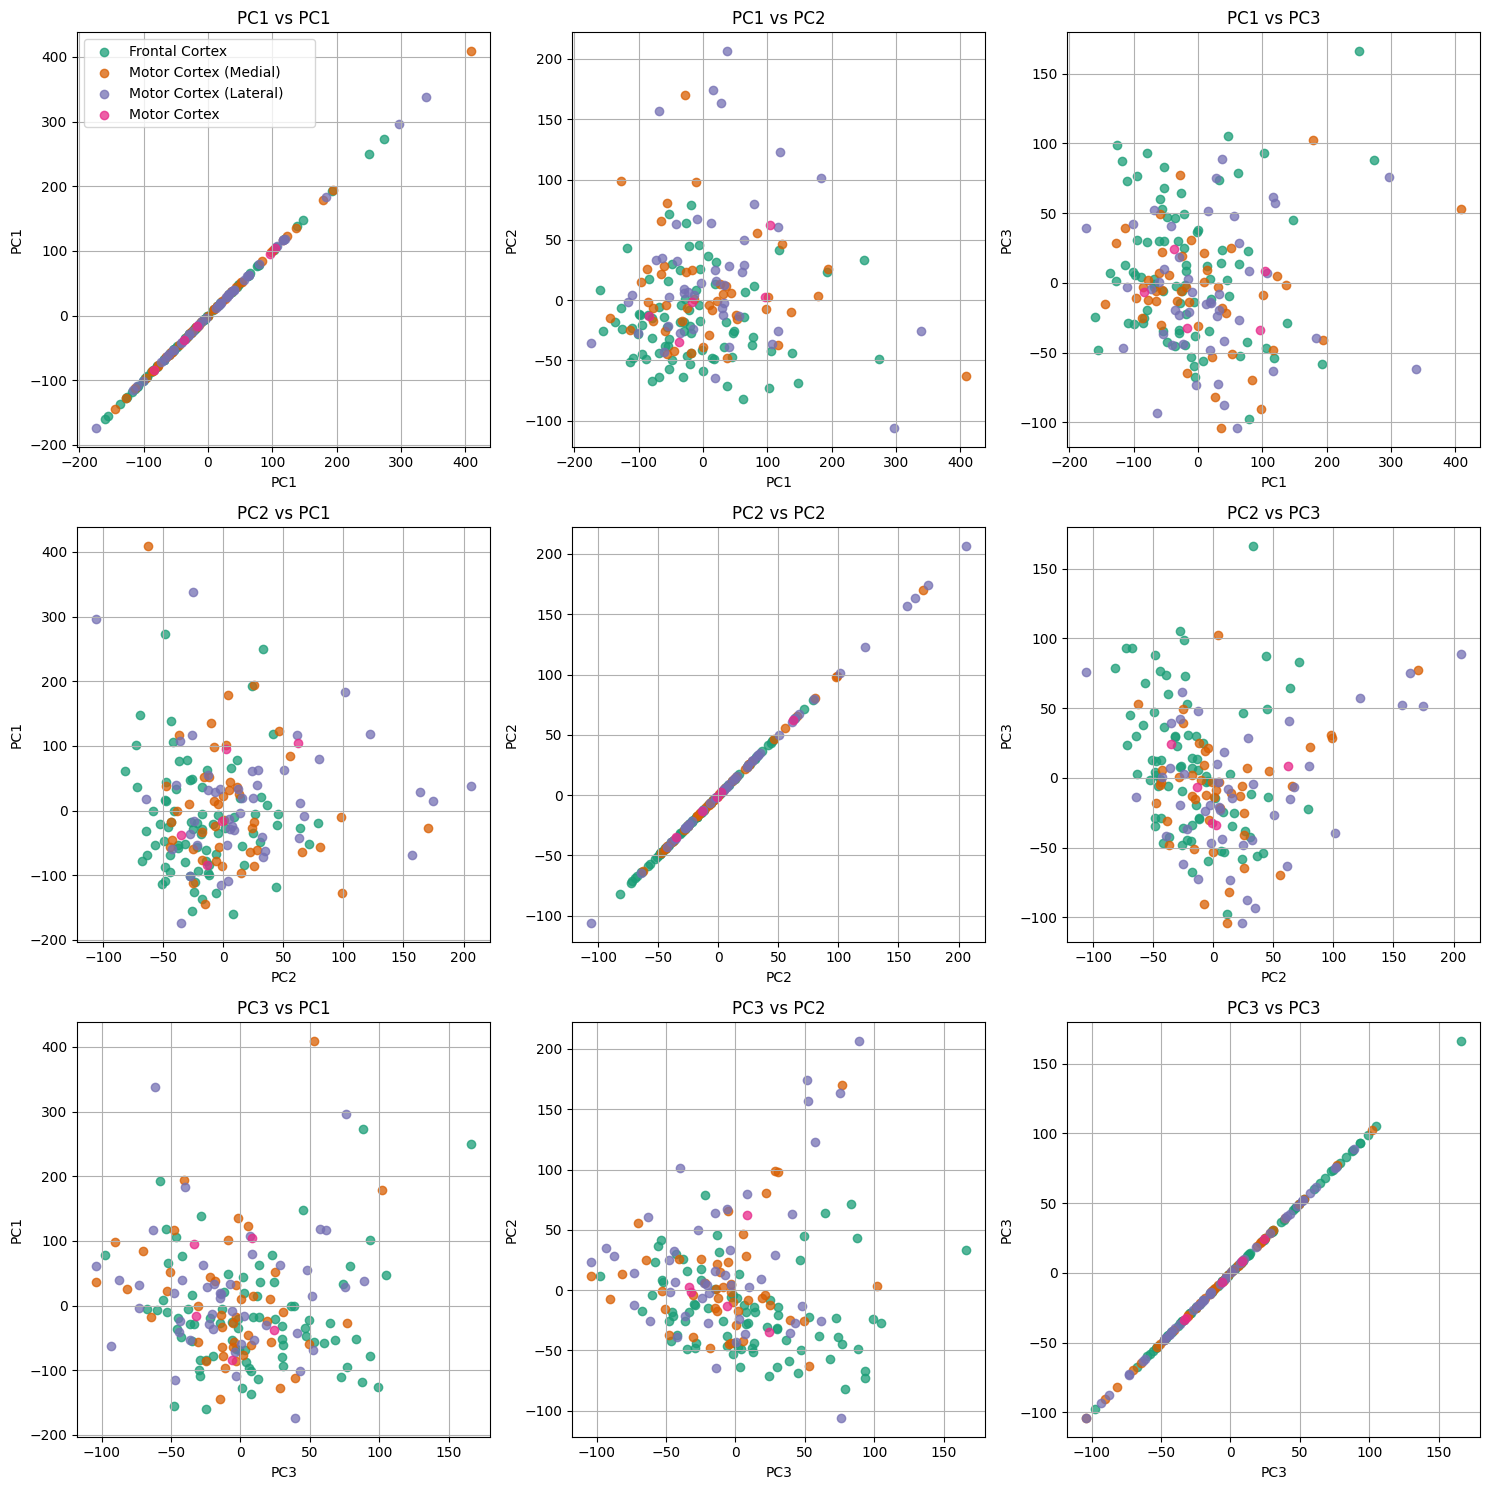

In [49]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn library

# Define the columns to use for PCA analysis
columns_pca = data_matrix.columns

# Define the column for color
color_column = 'Cns_subregion'

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_matrix[columns_pca])

# Perform a single PCA analysis for PC1, PC2 and PC3
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# Get the unique groups for color
groups = data_annotation[color_column].unique()

# Create a figure with a grid of subplots 3x3
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Perform PCA analysis for PC1, PC2 and PC3
for i in range(3):
    for j in range(3):
        # Plot the scatter plot for each group with specified color palette
        for idx, group in enumerate(groups):
            indices = data_annotation[color_column] == group
            axes[i, j].scatter(X_pca[indices, i], X_pca[indices, j], label=group, alpha=0.75, color=sns.color_palette("Dark2")[idx])

        # Title, labels, and legend only for the first plot
        if i == 0 and j == 0:
            axes[i, j].set_title(f'PC{i+1} vs PC{j+1}')
            axes[i, j].set_xlabel(f'PC{i+1}')
            axes[i, j].set_ylabel(f'PC{j+1}')
            axes[i, j].legend()
        else:
            axes[i, j].set_title(f'PC{i+1} vs PC{j+1}')
            axes[i, j].set_xlabel(f'PC{i+1}')
            axes[i, j].set_ylabel(f'PC{j+1}')
        axes[i, j].grid(True)

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()


For the PCA above, we can see that it is quite difficult to differentiate between the different regions where the sample has been done.

## Step 4 - tSNE and UMAP (optional)

## Step 5 - Univariate Analysis

In [50]:
!pip install pydeseq2

In [51]:
import os
import pickle as pkl

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

In [52]:
SAVE = False  # whether to save the outputs of this notebook

if SAVE:
    # Replace this with the path to directory where you would like results to be
    # saved
    OUTPUT_PATH = "../output_files/synthetic_example"
    os.makedirs(OUTPUT_PATH, exist_ok=True)  # Create path if it doesn't exist

In [53]:
# Assigning 'data_matrix' to 'counts_df' variable
counts_df = data_matrix

# Assigning 'data_annotation' to 'metadata' variable
metadata = data_annotation

In [54]:
# Create an instance of DefaultInference with 8 CPUs
inference = DefaultInference(n_cpus=8)

# Create a DeseqDataSet object with specified parameters
dds = DeseqDataSet(
    counts=counts_df,  # Provide count data
    metadata=metadata,  # Provide metadata
    design_factors="Sample_group",  # Specify design factors
    refit_cooks=True,  # Specify if Cook's distance should be refitted
    inference=inference  # Provide the inference object
)

<ipython-input-54-a753a4c18fd8>:5: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(


In [55]:
# Fit size factors
dds.fit_size_factors()

# Fit gene-wise dispersions
dds.fit_genewise_dispersions()

# Fit dispersion trend
dds.fit_dispersion_trend()

# Fit dispersion prior
dds.fit_dispersion_prior()

# Fit MAP dispersions
dds.fit_MAP_dispersions()

# Fit log-fold change (LFC)
dds.fit_LFC()

# Calculate Cook's distances
dds.calculate_cooks()

# Check if Cook's distances should be refitted
if dds.refit_cooks:
    # Refit if necessary
    dds.refit()

Fitting size factors...
... done in 0.63 seconds.

Fitting dispersions...
... done in 54.19 seconds.

Fitting dispersion trend curve...
... done in 0.91 seconds.

Fitting MAP dispersions...
... done in 68.48 seconds.

Fitting LFCs...
... done in 29.91 seconds.

Replacing 221 outlier genes.

Fitting dispersions...
... done in 0.41 seconds.

Fitting MAP dispersions...
... done in 0.46 seconds.

Fitting LFCs...
... done in 0.44 seconds.



In [56]:
# Check if SAVE is True
if SAVE:
    # Define the path to save the pickled object
    file_path = os.path.join(OUTPUT_PATH, "dds_detailed_pipe.pkl")

    # Open the file for writing in binary mode
    with open(file_path, "wb") as f:
        # Serialize and save the 'dds' object using pickle
        pkl.dump(dds, f)

In [57]:
# Run DESeq2 analysis
dds.deseq2()

# Perform statistical analysis with DESeqStats
stat_res = DeseqStats(dds, alpha=0.05, cooks_filter=True, independent_filter=True)

# Run Wald test
stat_res.run_wald_test()

# Check if Cook's distance filtering is enabled
if stat_res.cooks_filter:
    # Apply Cook's distance filtering
    stat_res._cooks_filtering()

# Check if independent filtering is enabled
if stat_res.independent_filter:
    # Apply independent filtering
    stat_res._independent_filtering()
else:
    # Adjust p-values if independent filtering is not used
    stat_res._p_value_adjustment()

Fitting size factors...
... done in 0.40 seconds.

Fitting dispersions...
... done in 51.47 seconds.

Fitting dispersion trend curve...
... done in 1.58 seconds.

Fitting MAP dispersions...
... done in 69.77 seconds.

Fitting LFCs...
... done in 28.55 seconds.

Replacing 221 outlier genes.

Fitting dispersions...
... done in 0.71 seconds.

Fitting MAP dispersions...
... done in 0.48 seconds.

Fitting LFCs...
... done in 0.27 seconds.

Running Wald tests...
... done in 8.84 seconds.



In [58]:
stat_res.summary()

Log2 fold change & Wald test p-value: Sample-group Non-Neurological Control       vs ALS Spectrum MND      
                           baseMean  log2FoldChange     lfcSE      stat  \
A1BG                      35.993902        0.018089  0.142838  0.126642   
A1BG-AS1                 113.742747        0.052983  0.099893  0.530397   
A1CF                       0.155759       -0.590130  1.708666 -0.345375   
A2M                     2345.384523        0.119104  0.159463  0.746904   
A2M-AS1                   99.268405       -0.186492  0.098238 -1.898372   
...                             ...             ...       ...       ...   
X8_LINE:CR1:LINE         458.855014        0.058600  0.103845  0.564304   
X9_LINE:L1:LINE          109.576015       -0.073882  0.111311 -0.663748   
Zaphod2:hAT-Tip100:DNA   411.010268        0.065308  0.105927  0.616537   
Zaphod3:hAT-Tip100:DNA  1539.491230        0.107348  0.107400  0.999510   
Zaphod:hAT-Tip100:DNA   1710.104347        0.084253  0.097368  0.86

In [59]:
stat_res.lfc_shrink(coeff="Sample-group_Non-Neurological Control      _vs_ALS Spectrum MND      ")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: Sample-group Non-Neurological Control       vs ALS Spectrum MND      
                           baseMean  log2FoldChange     lfcSE      stat  \
A1BG                      35.993902        0.006795  0.086577  0.126642   
A1BG-AS1                 113.742747        0.030294  0.075337  0.530397   
A1CF                       0.155759       -0.006336  0.109602 -0.345375   
A2M                     2345.384523        0.045241  0.097033  0.746904   
A2M-AS1                   99.268405       -0.124386  0.094532 -1.898372   
...                             ...             ...       ...       ...   
X8_LINE:CR1:LINE         458.855014        0.028541  0.076621  0.564304   
X9_LINE:L1:LINE          109.576015       -0.034496  0.081143 -0.663748   
Zaphod2:hAT-Tip100:DNA   411.010268        0.032013  0.077917  0.616537   
Zaphod3:hAT-Tip100:DNA  1539.491230        0.077702  0.088396  0.999510   
Zaphod:hAT-Tip100:DNA   1710.104347        0.042462  0.07557

... done in 68.96 seconds.



In [60]:
# Check if SAVE is True
if SAVE:
    # Define the path to save the pickled object
    file_path = os.path.join(OUTPUT_PATH, "stat_results_detailed_pipe.pkl")

    # Open the file for writing in binary mode
    with open(file_path, "wb") as f:
        # Serialize and save the 'stat_res' object using pickle
        pkl.dump(stat_res, f)

Note: running Wald test on shrunk LFCs. Some sequencing datasets show better performance with the testing separated from the use of the LFC prior.
Running Wald tests...
... done in 24.60 seconds.



Log2 fold change & Wald test p-value: Sample-group Non-Neurological Control       vs ALS Spectrum MND      
                           baseMean  log2FoldChange     lfcSE      stat  \
A1BG                      35.993902        0.006795  0.142930  0.000000   
A1BG-AS1                 113.742747        0.030294  0.099975  0.000000   
A1CF                       0.155759       -0.006336  1.642148  0.000000   
A2M                     2345.384523        0.045241  0.159471  0.000000   
A2M-AS1                   99.268405       -0.124386  0.097940 -0.248991   
...                             ...             ...       ...       ...   
X8_LINE:CR1:LINE         458.855014        0.028541  0.103871  0.000000   
X9_LINE:L1:LINE          109.576015       -0.034496  0.111169  0.000000   
Zaphod2:hAT-Tip100:DNA   411.010268        0.032013  0.105959  0.000000   
Zaphod3:hAT-Tip100:DNA  1539.491230        0.077702  0.107408  0.000000   
Zaphod:hAT-Tip100:DNA   1710.104347        0.042462  0.097378  0.00

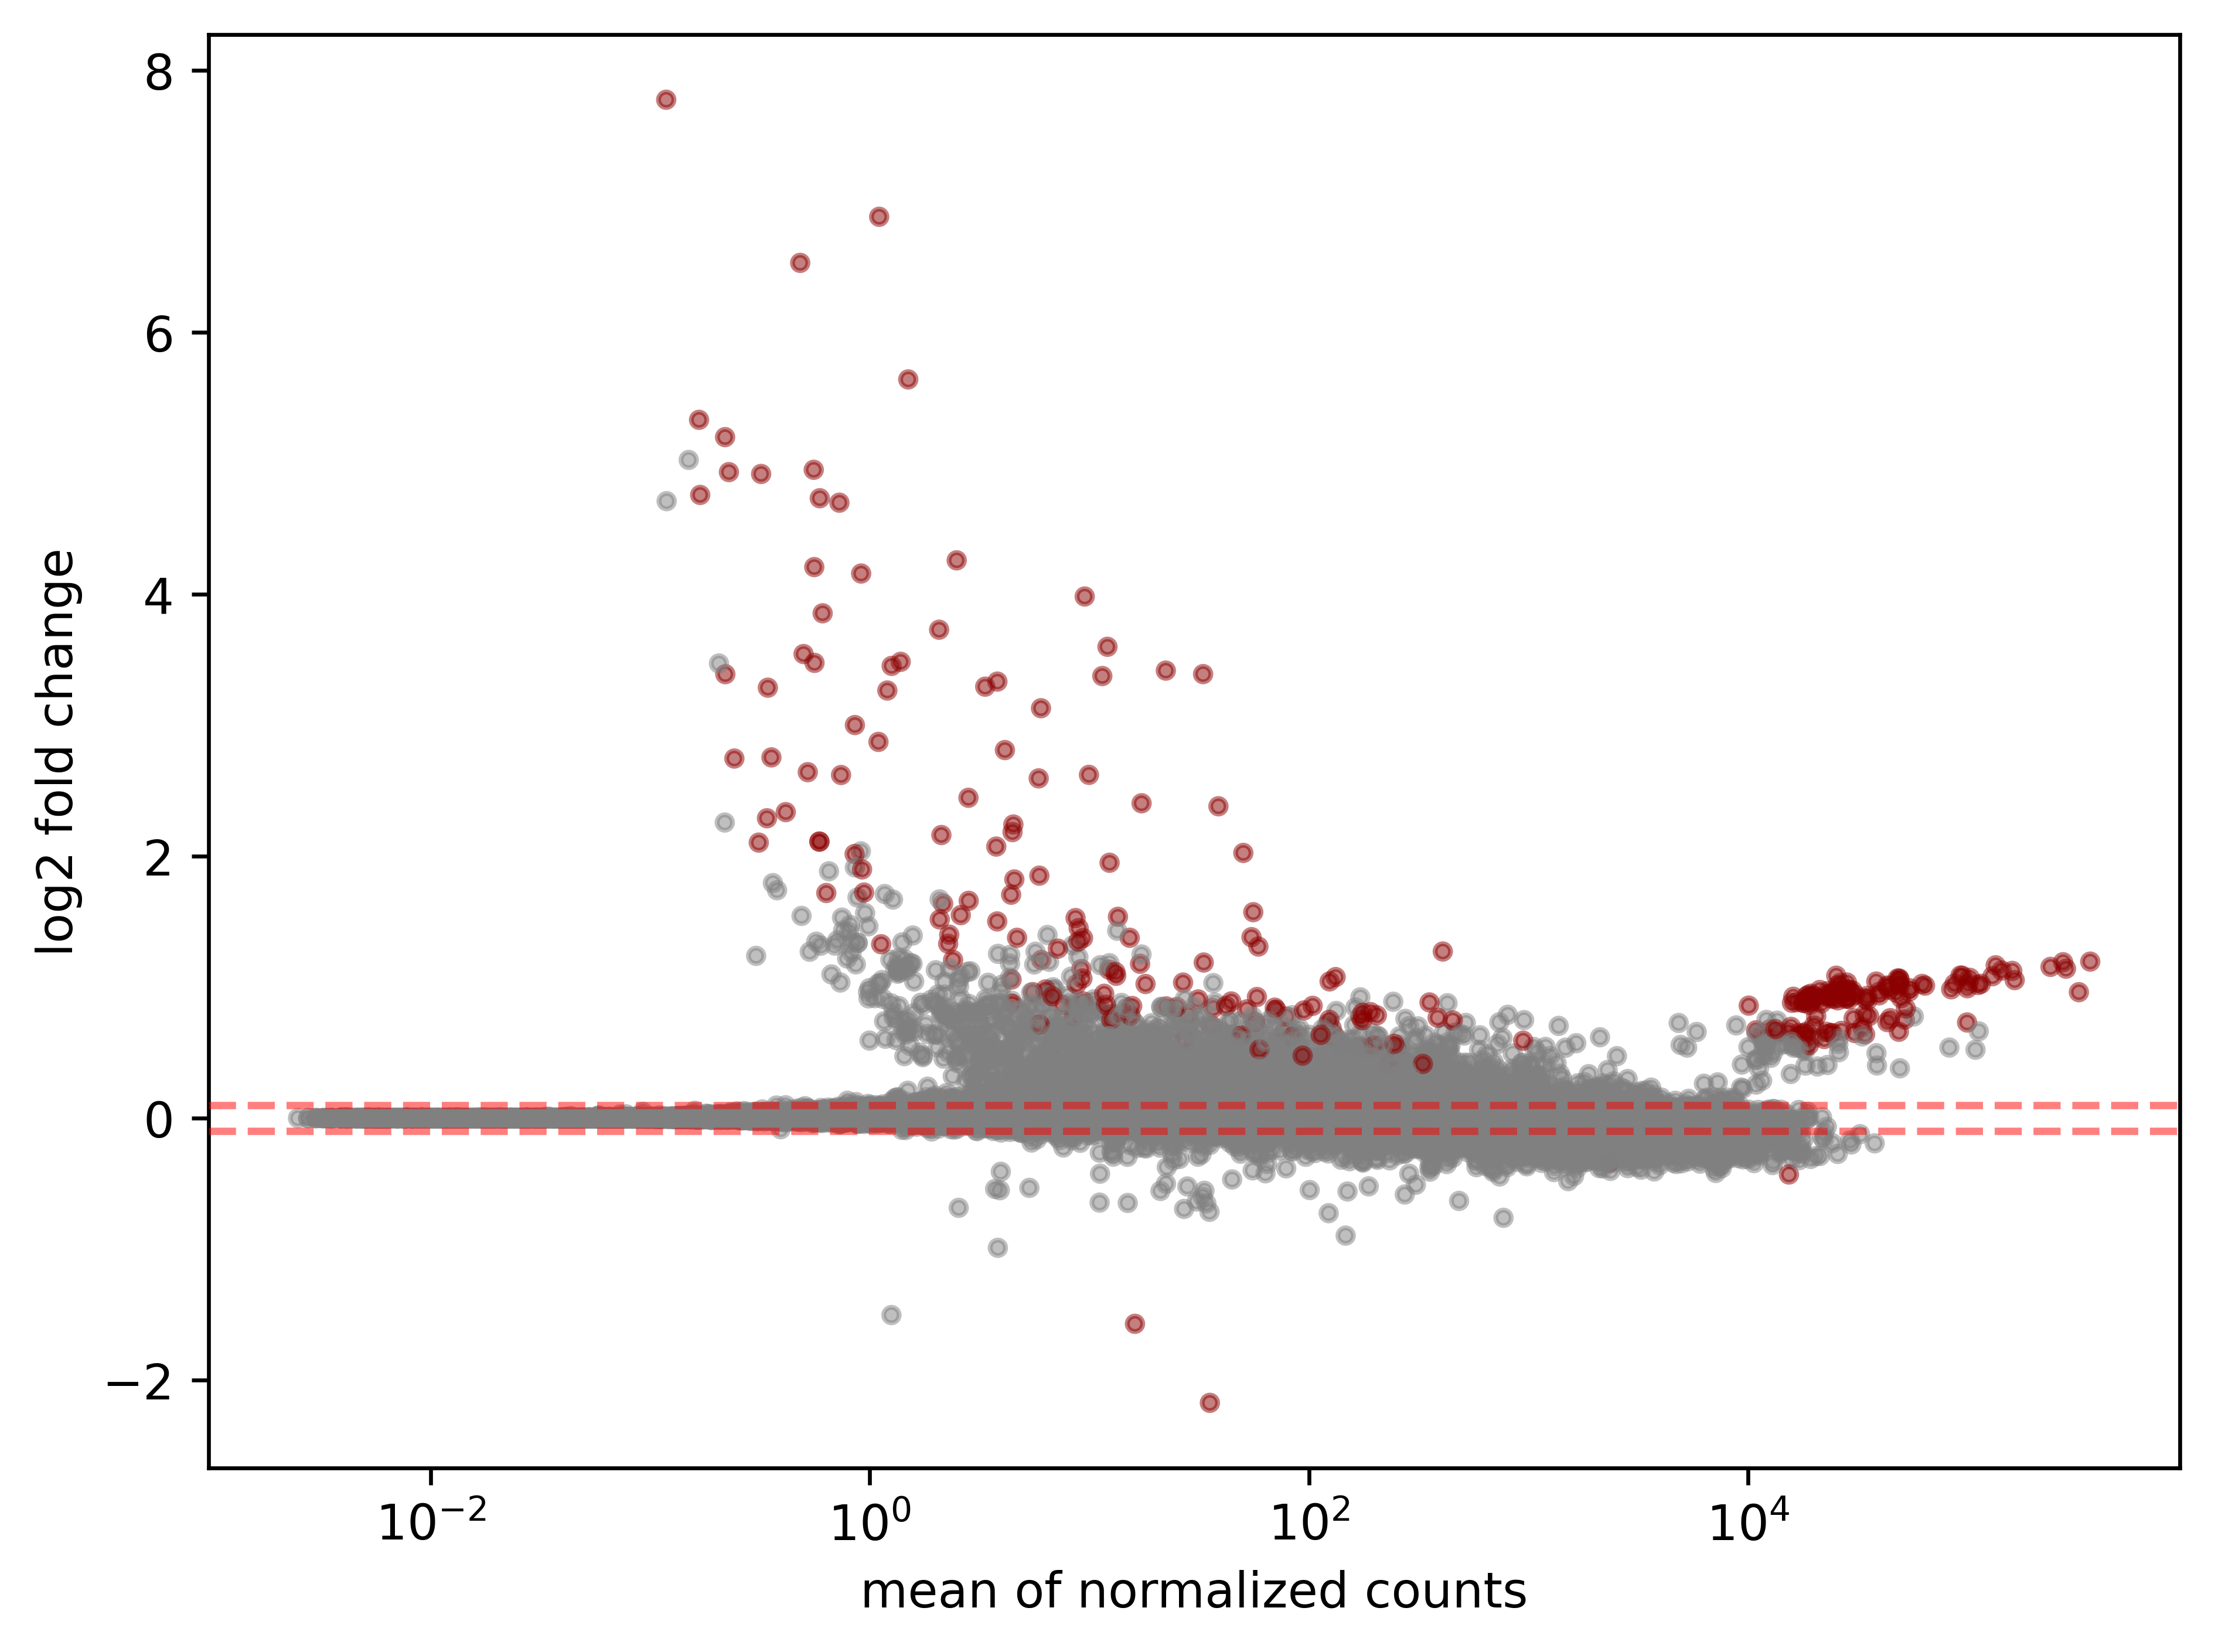

In [61]:
# Generate a summary of the statistical results
stat_res.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")

# Plot an MA plot using the statistical results
stat_res.plot_MA(s=10)

Here, we can see that most of the genes that are corresponding have positive values. We can also see that they are divided into 2 groups, the first one very grouped on the right and the other more dispersed.

## STEP 6 - Multivariate Analysis - Elastic-Net

In [62]:
# Assigning 'data_matrix' to variable 'x'
x = data_matrix

# Stripping leading and trailing whitespaces and converting to lowercase for 'Sample_group' column in 'data_annotation'
data_annotation['Sample_group'] = data_annotation['Sample_group'].str.strip().str.lower()

# Creating a boolean mask where 'Sample_group' equals 'als spectrum mnd'
y = data_annotation['Sample_group'] == 'als spectrum mnd'

In [63]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Fit logistic regression model with elastic net regularization
elasticNet = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, C=0.5).fit(x, y)

# Fit logistic regression model with elastic net regularization and cross-validation
elasticNet = LogisticRegressionCV(penalty='elasticnet', cv=3, solver='saga', l1_ratios=[0.25, 0.5, 0.75], Cs=[0.1, 0.5], scoring='accuracy').fit(x, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

In [64]:
from sklearn.metrics import accuracy_score

# Predict using the trained elasticNet model
model_prediction = elasticNet.predict(x)

# Calculate accuracy score on the training dataset
accuracy_train_dataset = accuracy_score(y, model_prediction)

In [65]:
print(elasticNet.coef_)

[[-2.15671745e-09  3.99821615e-09  6.63939503e-11 ...  2.23597679e-08
   6.23901504e-09  3.90975493e-10]]


In [66]:
# Get the column names from the data matrix
columns = data_matrix.columns

# Create a DataFrame with coefficients of the trained elasticNet model
df = pd.DataFrame(elasticNet.coef_)

# Assign column names to the DataFrame
df.columns = columns

# Calculate absolute coefficient values for each gene
row_abs_values = df.abs().iloc[0]

# Sort the DataFrame columns based on absolute coefficient values in descending order
df_sorted = df.reindex(columns=row_abs_values.sort_values(ascending=False).index)

# Select the first 100 columns from the sorted DataFrame
first_100_columns = df_sorted.iloc[:, :100]

# Get the genes names of the first 100 selected features
candidates = first_100_columns.columns

By sorting our genes based on the absolute value of the elasticNet.coef_ and selecting the first 100 genes with the highest value, we are selecting the best candidate for the genes causing ALS.

## STEP 7 - XGBOOST (optional)

## Conclusion

**Our 100 genes candidates for causing ALS are :**

In [67]:
# Iterate over each candidate feature
for i in range(len(candidates)):
    # Print the index, starting from 1, and the name of the candidate feature
    print(str(i + 1) + ") " + candidates[i])

1) RPPH1
2) GFAP
3) L1PA5:L1:LINE
4) SLC1A2
5) L1PA4:L1:LINE
6) KIF5A
7) L1PA3:L1:LINE
8) L1PA7:L1:LINE
9) SYT1
10) PLP1
11) SCD
12) XIST
13) CALM1
14) ZNF483
15) DST
16) L1M5:L1:LINE
17) AluJb:Alu:SINE
18) MBP
19) MIR3648-1
20) SPP1
21) L1PA2:L1:LINE
22) ACTB
23) ATRNL1
24) MAP2
25) SORT1
26) MEF2C
27) PSD3
28) L1PA6:L1:LINE
29) TF
30) AluJr:Alu:SINE
31) L1ME4a:L1:LINE
32) APC
33) L2b:L2:LINE
34) NORAD
35) IDS
36) L1PB1:L1:LINE
37) ENC1
38) MIR3648-2
39) VCAN
40) NEAT1
41) AHNAK
42) SLC1A3
43) TPPP
44) L2a:L2:LINE
45) CAMK2A
46) NEFH
47) AluJo:Alu:SINE
48) HSP90AA1
49) CADM2
50) SYT11
51) OIP5-AS1
52) RMRP
53) RTN3
54) NECAB1
55) SCN2A
56) SERPINA3
57) MIR663AHG
58) APP
59) ATP1A2
60) DPYSL2
61) PRKACB
62) GAS7
63) L3:CR1:LINE
64) CLSTN1
65) ABCA2
66) MIRb:MIR:SINE
67) PPP3CA
68) MOBP
69) MAP4K4
70) PGM2L1
71) CPE
72) HSPA8
73) GRIN2B
74) MTSS1L
75) PREPL
76) CNP
77) ATP8A1
78) L1ME1:L1:LINE
79) ATP2B1
80) TSC22D1
81) ADGRV1
82) SPOCK1
83) FAIM2
84) AQP4
85) YWHAH
86) PTPRZ1
87) TMOD2

Some of the genes in this candidate list were revealed to be likely to cause ALS in step 2 when we looked at the genes with the highest and lowest means. This list therefore confirms certain suspicions that we had.